# MODELIZACIÓN PARA NO SUPERVISADO

## IMPORTAR PAQUETES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA


#Desactivar la notación científica
pd.options.display.float_format = '{:.2f}'.format

#Desactivar los warnings
import warnings
warnings.filterwarnings("ignore")

## IMPORTAR LOS DATOS

Ruta del proyecto.

In [3]:
ruta_proyecto = 'C:/Users/Alfonso/OneDrive/Documentos_/Formación/Bootcamp_DS/Repo_DS/Proyect_Break_ML/Proyecto_ML/00_PROYECTO_ML'

Nombres de los ficheros de datos.

In [4]:
nombre_df_transformaciones = 'df_tablon.pickle'
nombre_df_sin_transformar = 'df_resultado_eda.pickle'

In [5]:
df = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_df_transformaciones)
df_sin_transformar = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_df_sin_transformar)

In [6]:
df.columns

Index(['marital_status_Divorced', 'marital_status_Married',
       'marital_status_OTROS', 'marital_status_Single',
       'marital_status_Together', 'marital_status_Widow', 'acceptedcmp3',
       'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1', 'acceptedcmp2',
       'complain', 'response', 'education_oe_mms', 'income_mms', 'recency_mms',
       'mntwines_mms', 'mntfruits_mms', 'mntmeatproducts_mms', 'kidhome_mms',
       'teenhome_mms', 'mntfishproducts_mms', 'mntsweetproducts_mms',
       'mntgoldprods_mms', 'numdealspurchases_mms', 'numwebpurchases_mms',
       'numcatalogpurchases_mms', 'numstorepurchases_mms',
       'numwebvisitsmonth_mms', 'age_mms', 'household_members_mms',
       'total_amount_mms', 'total_purchase_mms', 'median_amount_purchase_mms',
       'total_cmp_mms', 'total_%_cmp_mms'],
      dtype='object')

En esta parte voy haciendo selección de columnas a eliminar para ir quedándome con las que muestren mayor diferencia entre clúster (Ensayo y error tras visualización.)

In [7]:
features_cmp = df.filter(like = 'accepted').columns
features_others = ['complain', 'education_oe_mms','recency_mms','numdealspurchases_mms','age_mms','total_%_cmp_mms']
feature_marital = df.filter(like = 'status').columns
features_pruebas = list(set(features_cmp) | set(features_others) | set(feature_marital))

In [8]:
df_copy = df.copy()
df_pruebas = df_copy.drop(columns=(features_pruebas))

## MODELIZAR

### Crear el espacio de soluciones

In [9]:
min_k = 2
max_k = 6

soluciones = list(range(min_k,max_k))

### Crear listas para guardar la salida de cada métrica

In [10]:
codo = []
silueta = []
calins = []
davies = []

### Analizar el espacio de soluciones

In [11]:
for solucion in soluciones:
    
    #Instanciar
    cluster = KMeans(n_clusters = solucion, n_init=10)
    
    #Entrenar
    cluster.fit(df_pruebas)
    
    #Recoger las métricas
    codo.append(cluster.inertia_)
    silueta.append(silhouette_score(df_pruebas, cluster.labels_))
    calins.append(calinski_harabasz_score(df_pruebas, cluster.labels_))
    davies.append(davies_bouldin_score(df_pruebas, cluster.labels_))

### Identificar la mejor solucion

#### Analizar las métricas

In [12]:
metricas = pd.DataFrame({'Solucion':soluciones,
              'Codo': codo,
              'Silueta':silueta,
              'Calins':calins,           
              'Davies':davies}).set_index('Solucion')

metricas

Codo  Silueta  Calins  Davies
Solucion                                
2        954.46     0.35  831.69    1.28
3        819.30     0.34  606.03    1.48
4        731.15     0.27  511.77    1.59
5        651.79     0.29  475.20    1.47

#### Analizar los gráficos

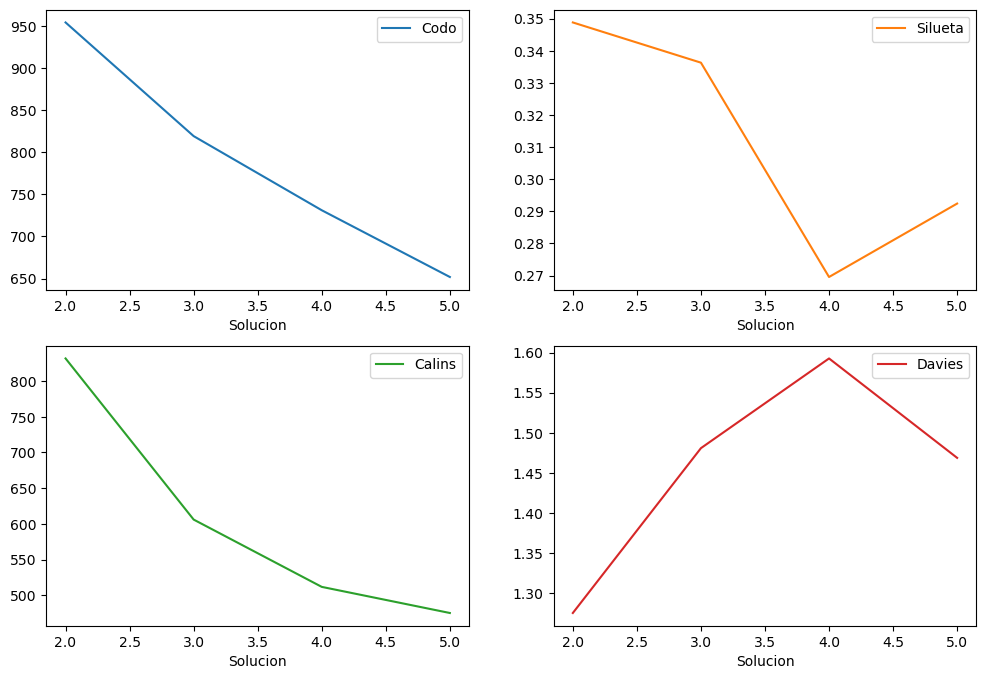

In [13]:
metricas.plot(subplots = True, figsize = (12,8), layout = (2,2), sharex = False);

### Segmentación final con la mejor solucion

In [14]:
mejor_solucion =2

#Instanciar
cluster = KMeans(n_clusters = mejor_solucion, n_init=10)
    
#Entrenar
cluster.fit(df_pruebas)

KMeans(n_clusters=2, n_init=10)

#### Visualización clúster

In [15]:
# Reducir las dimensiones a 2D usando PCA para la visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_pruebas)

# Obtenemos las etiquetas del cluster del paso 'kmeans'
labels = cluster.labels_

# Obtenemos los centroides de los clusters en el espacio original
cluster_centers = cluster.cluster_centers_

# Transformamos los centroides al espacio PCA
cluster_centers_pca = pca.transform(cluster_centers)


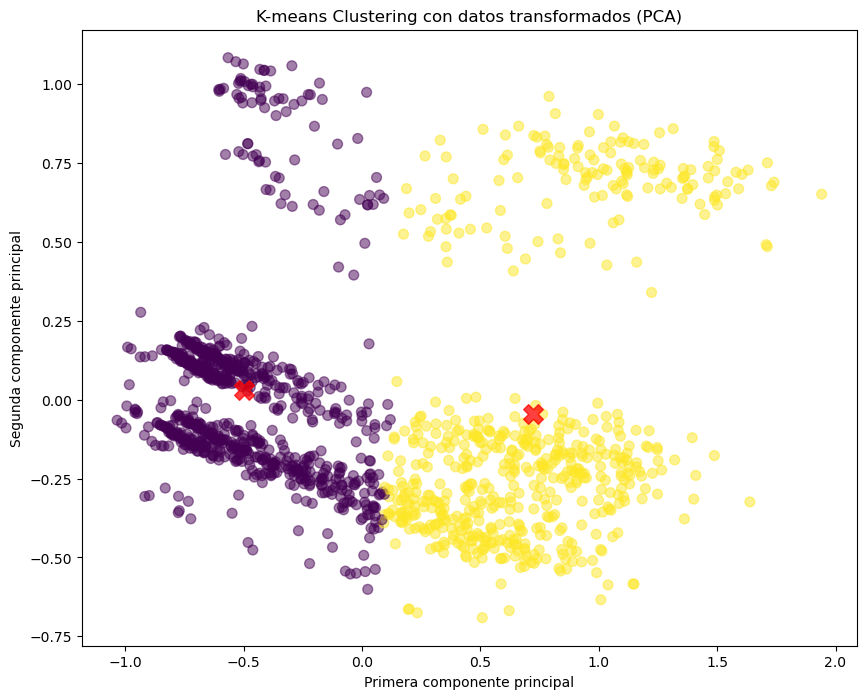

In [16]:
# Crear una figura para los datos transformados con PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis', marker='o', alpha=0.5)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-means Clustering con datos transformados (PCA)')
plt.xlabel('Primera componente principal')
plt.ylabel('Segunda componente principal')
plt.show()

## EVALUAR

### Calcular el segmento en entrenamiento y en validación

In [17]:
df_pruebas['segmento'] = cluster.predict(df_pruebas)

In [18]:
df_pruebas['segmento'].value_counts(True)

segmento
0   0.59
1   0.41
Name: proportion, dtype: float64

In [19]:
df_pruebas.describe().T.round(2)

count  mean  std  min  25%  50%  75%  max
response                   1481.00  0.15 0.36 0.00 0.00 0.00 0.00 1.00
income_mms                 1481.00  0.43 0.20 0.00 0.27 0.42 0.58 1.00
mntwines_mms               1481.00  0.21 0.24 0.00 0.02 0.12 0.35 1.00
mntfruits_mms              1481.00  0.15 0.22 0.00 0.01 0.04 0.18 1.00
mntmeatproducts_mms        1481.00  0.17 0.23 0.00 0.01 0.06 0.24 1.00
kidhome_mms                1481.00  0.23 0.27 0.00 0.00 0.00 0.50 1.00
teenhome_mms               1481.00  0.25 0.27 0.00 0.00 0.00 0.50 1.00
mntfishproducts_mms        1481.00  0.15 0.23 0.00 0.01 0.05 0.20 1.00
mntsweetproducts_mms       1481.00  0.14 0.21 0.00 0.01 0.04 0.18 1.00
mntgoldprods_mms           1481.00  0.18 0.21 0.00 0.03 0.10 0.23 1.00
numwebpurchases_mms        1481.00  0.15 0.10 0.00 0.07 0.11 0.22 1.00
numcatalogpurchases_mms    1481.00  0.24 0.26 0.00 0.00 0.18 0.36 1.00
numstorepurchases_mms      1481.00  0.39 0.27 0.00 0.17 0.33 0.58 1.00
numwebvisitsmonth_mms      1481.00  0.39 0.21 0.00 0.18 0.45 0.55 1.00
household_members_mms      1481.00  0.40 0.22 0.00 0.25 0.50 0.50 1.00
total_amount_mms           1481.00  0.24 0.24 0.00 0.02 0.14 0.41 1.00
total_purchase_mms         1481.00  0.40 0.22 0.00 0.18 0.41 0.59 1.00
median_amount_purchase_mms 1481.00  0.03 0.04 0.00 0.01 0.02 0.04 1.00
total_cmp_mms              1481.00  0.08 0.17 0.00 0.00 0.00 0.00 1.00
segmento                   1481.00  0.41 0.49 0.00 0.00 0.00 1.00 1.00

Aplico al dataset sin transformaciones las predicciones dado que se ha mantenido el ID en ambos dataset (df_tablón y df_sin_transformar)

In [20]:
df_sin_transformar['segmento'] = df_pruebas['segmento']

In [21]:
df_sin_transformar['segmento'].value_counts(True)

segmento
0   0.59
1   0.41
Name: proportion, dtype: float64

Correcto!!!. Tienen la misma proporción

### Pairplot con las variables vs los clúster creados

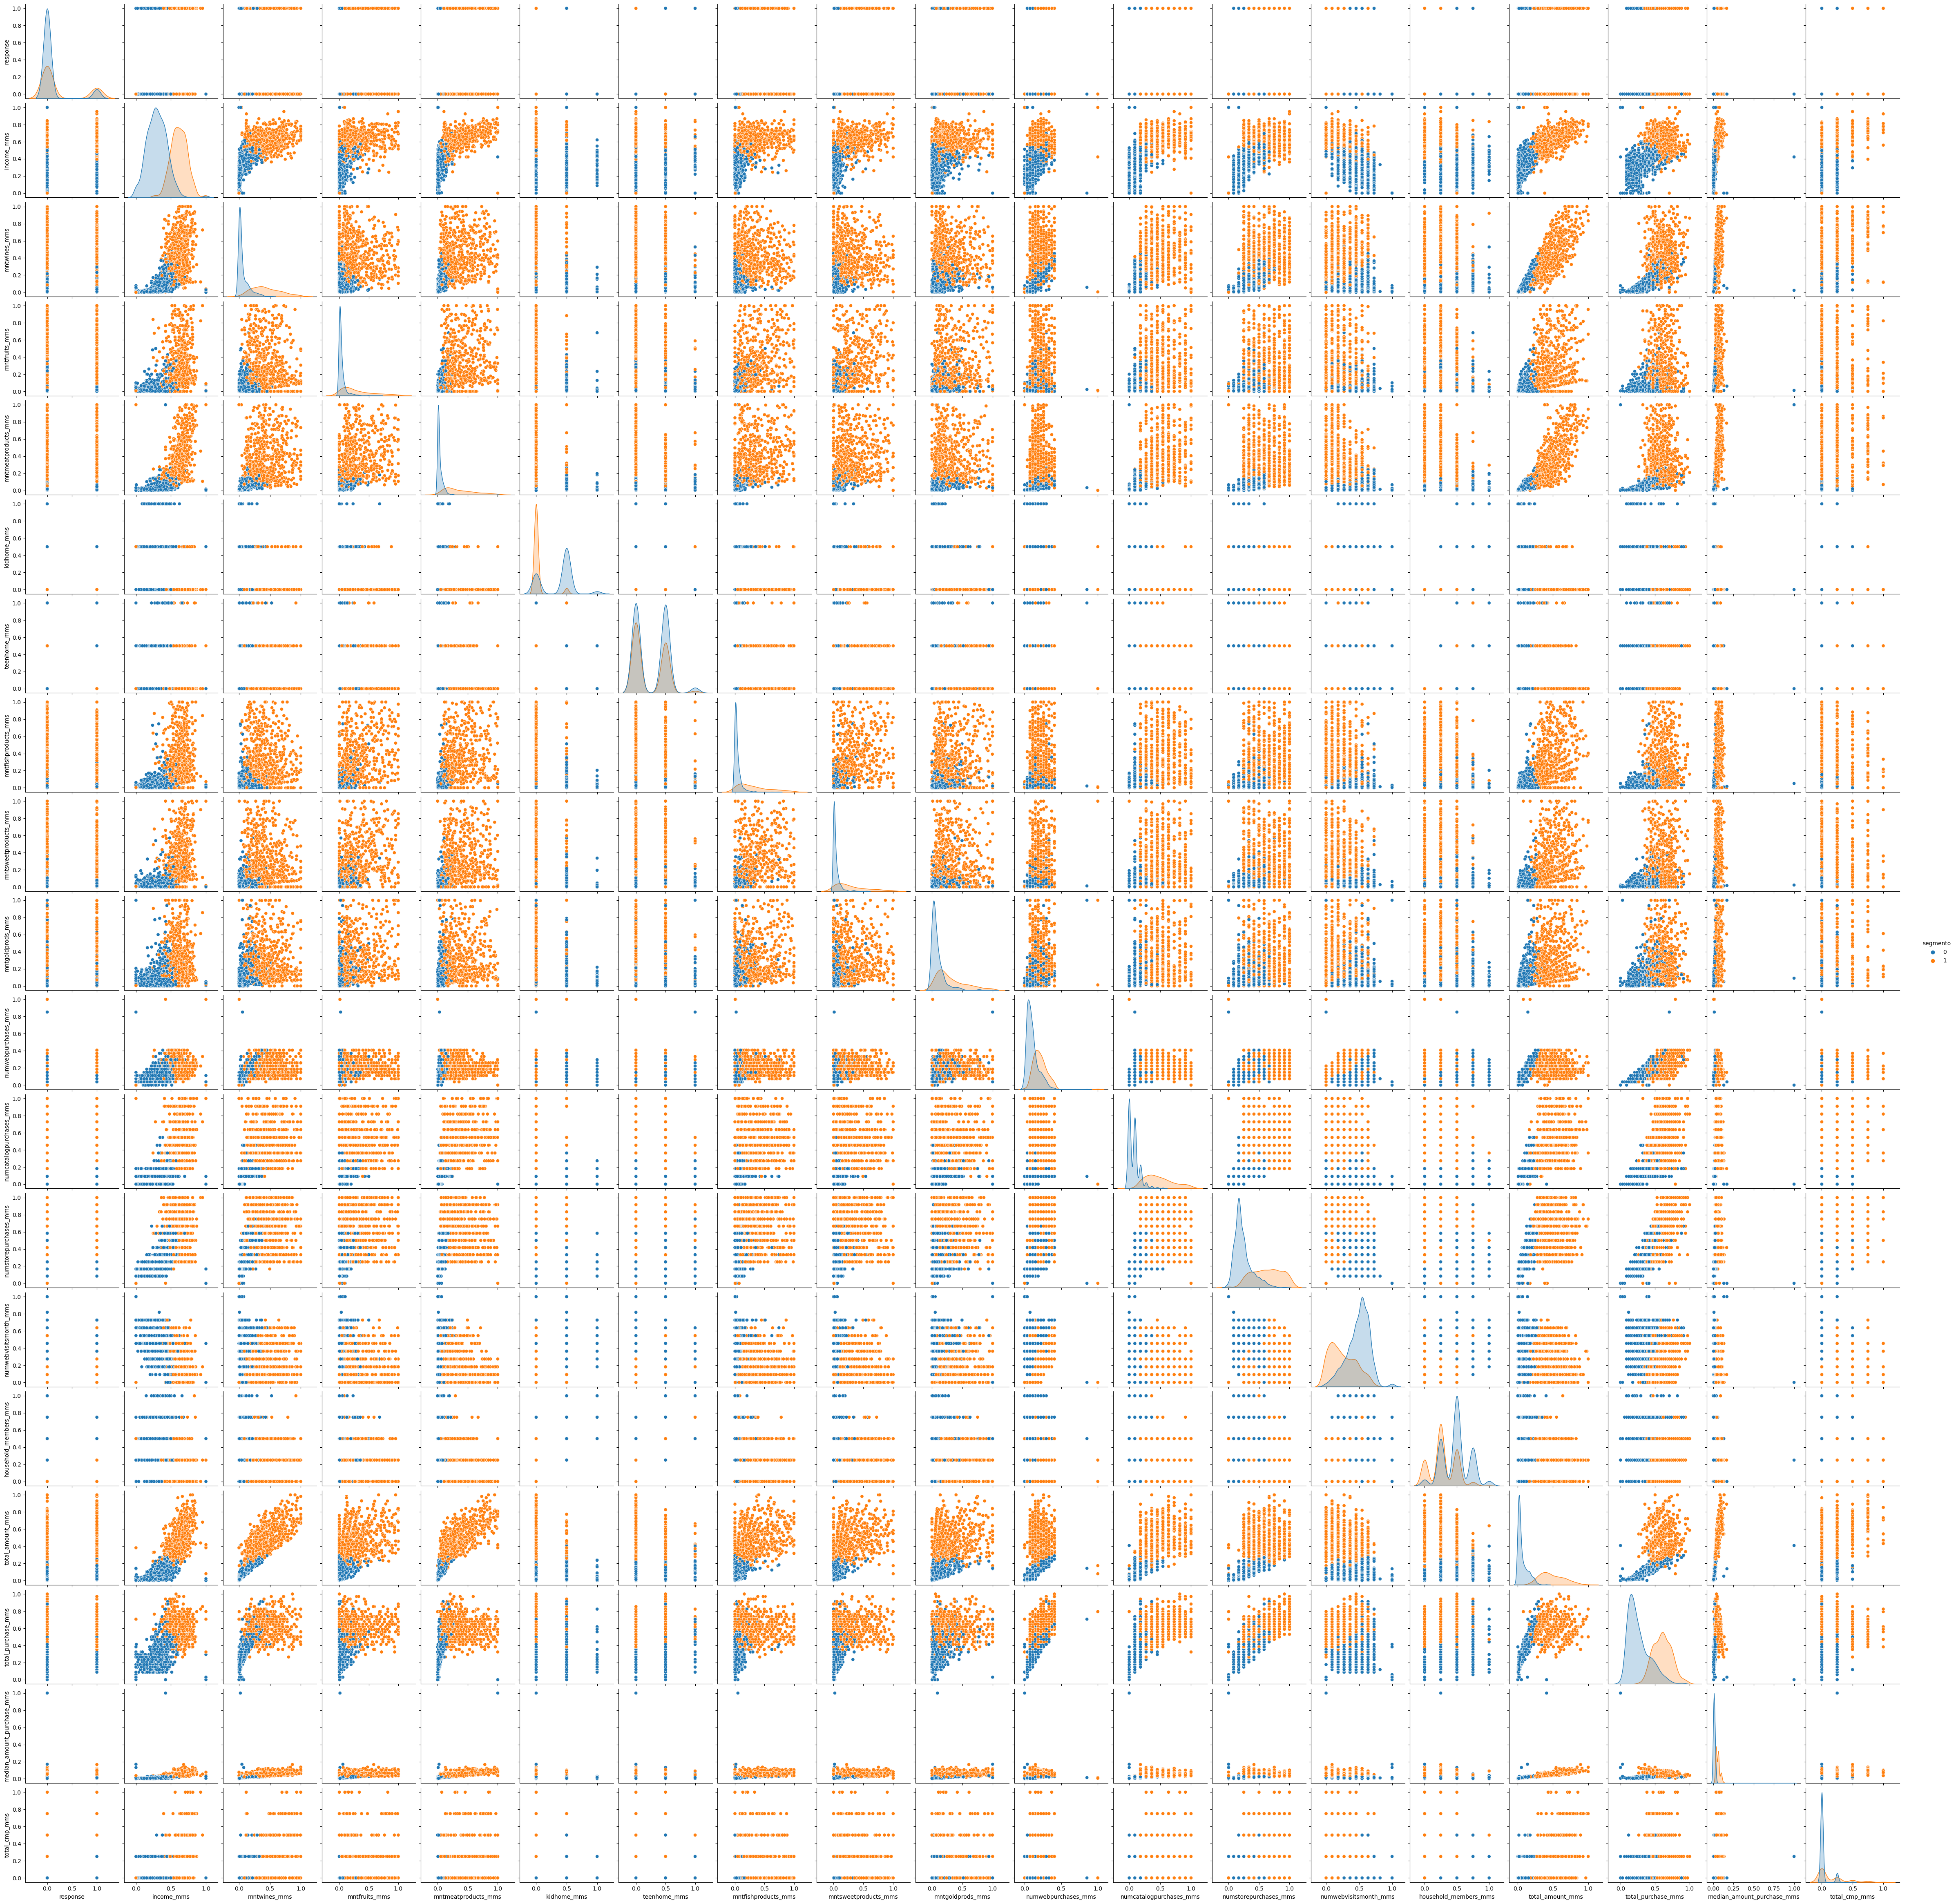

In [ ]:
sns.pairplot(df_pruebas, hue='segmento');

## PERFILAR LOS SEGMENTOS

In [ ]:
df_pruebas.groupby('segmento').mean().T \
    .style.highlight_max(color = 'lightgreen', axis = 1) \
    .highlight_min(color = 'red', axis = 1)

### Gráficos de radar por clúster

In [ ]:
from math import pi
datos_grafico = df_pruebas.groupby('segmento').mean().T 

def create_radar_chart(df):
    categories = list(df[0].index)
    N = len(categories)
    
    # Crear un gráfico de radar para cada segmento
    for segment in df.columns[:]:
        values = df[segment].values.flatten().tolist()
        values += values[:1]
        
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
        
        ax = plt.subplot(111, polar=True)
        
        plt.xticks(angles[:-1], categories, color='grey', size=8)
        
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=segment)
        ax.fill(angles, values, alpha=0.1)
        
        plt.title(f'Segmento {segment}')
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.show()



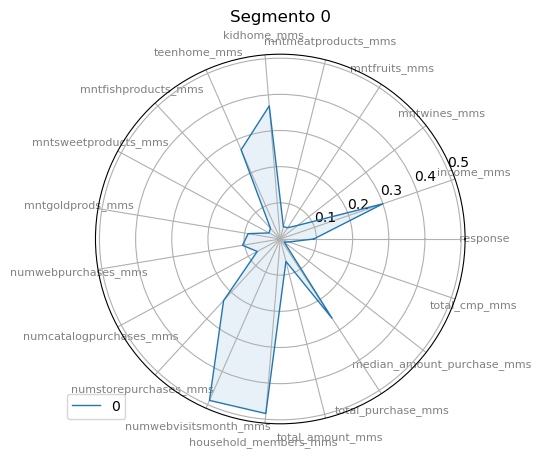

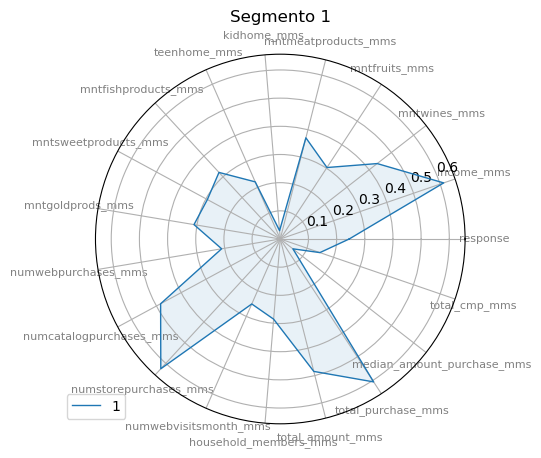

In [ ]:
create_radar_chart(datos_grafico)

### Gráfico de radar combinado

In [ ]:
def create_combined_radar_chart(df):
    categories = list(df[0].index)
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for segment in df.columns:
        values = df[segment].values.flatten().tolist()
        values += values[:1]
        
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Segmento {segment}')
        ax.fill(angles, values, alpha=0.1)
    
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    plt.title('Comparación de Segmentos')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()


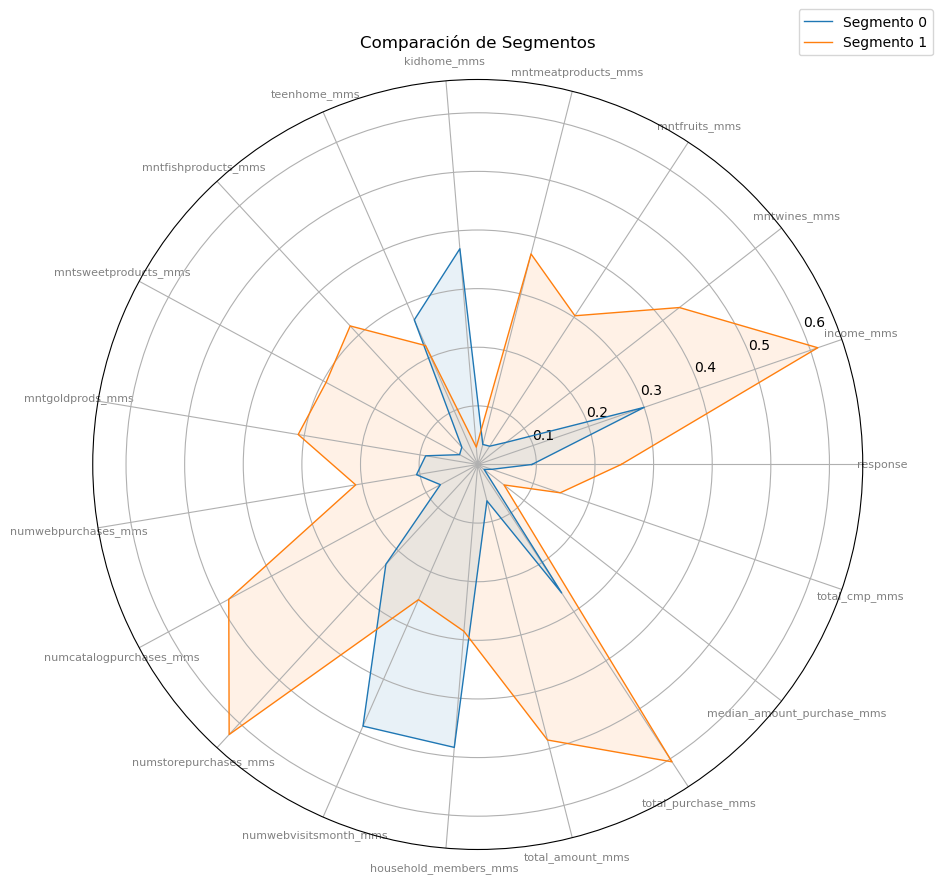

In [ ]:
create_combined_radar_chart(datos_grafico)

## GUARDADO DE LOS DATASET

In [ ]:
#Definir los nombres de los archivos
ruta_df_pickle = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_resultado_cluster_2.pickle'
ruta_df_csv = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_resultado_cluster_2.csv'
ruta_df_grafico_csv = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_grafico_2.csv'

In [ ]:
#Guardar los archivos
df_sin_transformar.to_pickle(ruta_df_pickle)
df_sin_transformar.to_csv(ruta_df_csv)
datos_grafico.to_csv(ruta_df_grafico_csv)